In [1]:
using ForwardDiff
using Printf
using PyPlot
using PorousMaterials
using Colors
using ColorSchemes
using LaTeXStrings
using DataFrames
using SymPy

PyPlot.matplotlib.style.use("seaborn-pastel")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

const R = 8.31446e-3 # kJ/(mol-K)
const RT = R * 298.0 # KJ/mol at room temperature

2.47770908

# Data structure for a MORF

In [2]:
struct Material
    δ::Float64
    ϵ♡::Float64
    ϵ△::Float64
end

function Base.show(io::IO, material::Material)
    @printf("MORF material with:\n\tδ = %.3f\n\tϵ♡ = %.3f\n\tϵ△ = %.3f\n", material.δ, material.ϵ♡, material.ϵ△)
end

# Adsorption isotherm of a MORF

\begin{equation}
    \langle n \rangle(P) = \dfrac{K \beta P}{1+K \beta P}
\end{equation} where:
\begin{equation}
K=K(\beta; \delta, \epsilon_\heartsuit, \epsilon_\triangle)=\dfrac{1}{1+e^{-\beta\delta}}e^{-\beta \epsilon_\triangle} + \dfrac{e^{-\beta\delta}}{1+e^{-\beta\delta}}e^{-\beta \epsilon_\heartsuit}
\end{equation}.

In [3]:
function K(material::Material, β::Real) # must assert β::Real as opposed to β::Float64 for ForwardDiff.jl to work
    p_ring_on_♡ = 1 / (1 + exp(-β * material.δ)) # probability ring is on ♡ when gas is absent
    return p_ring_on_♡ * exp(-β * material.ϵ△) + (1 - p_ring_on_♡) * exp(-β * material.ϵ♡)
end

function expected_n(material::Material, β::Real, P::Float64) # must use Real for ForwardDiff.jl
    KβP = K(material, β) * β * P
    return KβP / (1.0 + KβP)
end

expected_n (generic function with 1 method)

plot a generic isotherm for the paper

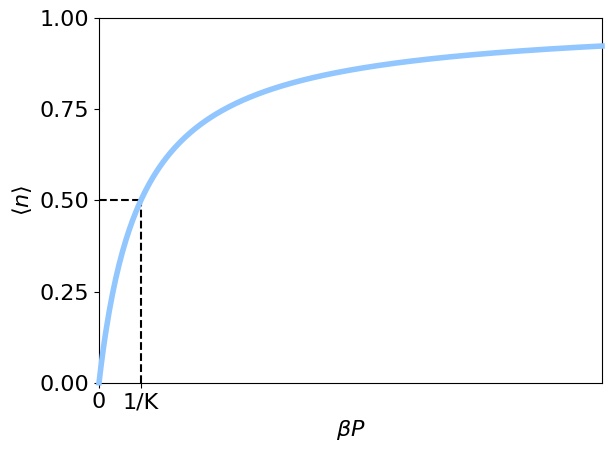

In [4]:
material = Material(1.0, -1.0, -1.5)
βP = range(0.0, stop=3.0, length=300)
n = [expected_n(material, 1.0, βP_i) for βP_i in βP]

figure()
# grid("on", linestyle="--", zorder=2)

βP_half_max = 1 / K(material, 1.0)
plot([βP_half_max, βP_half_max], [0.0, 0.5], color="k", linestyle="--")
plot([0, βP_half_max], [0.5, 0.5], color="k", linestyle="--")

xlabel(L"$\beta P$")
ylabel(L"$\langle n \rangle$")

plot(βP, n, lw=4, clip_on=false, zorder=100)
xlim([0.0, maximum(βP)]) # keep this after line above
ylim([0.0, 1.0])

xticks([0, βP_half_max], [0, "1/K"])
yticks([i * 0.25 for i = 0:4])
tight_layout()
savefig("adsorption_isotherm.pdf", format="pdf")

# Temperature-dependence of $\langle n \rangle$

we will use both autodifferentiation and symbolic differentiation with substitution via `SymPy`.

In [5]:
function _Kβ_symbolic()
    β = Sym("β")
    ϵ♡ = Sym("ϵ♡")
    ϵ△ = Sym("ϵ△")
    δ = Sym("δ")
    
    return β * (1/(1+exp(-β*δ)) * (exp(-β*ϵ△) + exp(-β*(ϵ♡+δ))))
end

const Kβ_MORF_symbolic = _Kβ_symbolic()

function _∂Kβ_∂β_symbolic()
    return diff(Kβ_MORF_symbolic, "β")
end

const ∂Kβ_∂β_MORF_symbolic = _∂Kβ_∂β_symbolic()

function eval_sym(sym::Sym, material::Material, β::Float64)
    params = Dict("β" => β, "ϵ♡" => material.ϵ♡, "ϵ△" => material.ϵ△, "δ" => material.δ)
    return convert(Float64, sym.subs(params))
end

# a test
material = Material(rand(), -rand(), -rand())
β = rand()
params = Dict("β" => β, "ϵ♡" => material.ϵ♡, "ϵ△" => material.ϵ△, "δ" => material.δ)
@assert isapprox(K(material, β) * β, eval_sym(Kβ_MORF_symbolic, material, β))

note: this is only a function of $\beta (\delta, \epsilon_\heartsuit, \epsilon_\bigtriangleup)$.

In [6]:
simplify(∂Kβ_∂β_MORF_symbolic)

⎛    ⎛ β⋅ϵ△    β⋅(δ + ϵ♡)⎞   ⎛ β⋅δ    ⎞ ⎛    ⎛    β⋅(δ + ϵ♡)             β⋅ϵ△⎞
⎝β⋅δ⋅⎝ℯ     + ℯ          ⎠ + ⎝ℯ    + 1⎠⋅⎝- β⋅⎝ϵ△⋅ℯ           + (δ + ϵ♡)⋅ℯ    ⎠
──────────────────────────────────────────────────────────────────────────────
                                                                           2  
                                                                 ⎛ β⋅δ    ⎞   
                                                                 ⎝ℯ    + 1⎠   

    β⋅ϵ△    β⋅(δ + ϵ♡)⎞⎞  -2⋅β⋅(δ + ϵ△ + ϵ♡) + β⋅(2⋅δ + ϵ△ + ϵ♡)
 + ℯ     + ℯ          ⎠⎠⋅ℯ                                      
────────────────────────────────────────────────────────────────
                                                                
                                                                
                                                                

for a Langmuir material with energy of adsorption $\epsilon$...

In [7]:
function Kβ_Langmuir_symbolic()
    β = Sym("β")
    ϵ = Sym("ϵ")
    
    return β * exp(-β*ϵ)
end

function ∂Kβ_∂β_Langmuir_symbolic()
    return diff(Kβ_Langmuir_symbolic(), "β")
end

simplify(∂Kβ_∂β_Langmuir_symbolic())

            -β⋅ϵ
(-β⋅ϵ + 1)⋅ℯ    

Finally, functions to numerically evaluate the derivative of $K\beta$ w.r.t. $\beta$ for both Langmuir and RMS-MORF materials

In [8]:
function ∂Kβ_∂β_Langmuir(βϵ::Float64)
    return (1 - βϵ) * exp(-βϵ)
end

function ∂Kβ_∂β_MORF(material::Material, β::Float64)
    return eval_sym(∂Kβ_∂β_MORF_symbolic, material, β)
end

∂Kβ_∂β_MORF (generic function with 1 method)

In [9]:
function ∂Kβ_∂β_autodiff(material::Material, β::Float64)
    # view K as a function of β only.
    Kβ(x) = K(material, x[1]) * x[1] # x plays role of β
    ∂Kβ_∂β_of_β = x -> ForwardDiff.gradient(Kβ, x) # x plays role of β
    return ∂Kβ_∂β_of_β([β])[1]
end

# test with centered difference
ϵ = 1e-8 # spacing
@assert isapprox((K(material, β + ϵ) * (β + ϵ) - K(material, β - ϵ) * (β - ϵ)) / (2 * ϵ), 
    ∂Kβ_∂β_autodiff(material, β))

# test by comparing to symbolic
@assert isapprox(∂Kβ_∂β_autodiff(material, β), ∂Kβ_∂β_MORF(material, β))

In [10]:
function ∂n_∂β_autodiff(material::Material, β::Float64, P::Float64)
    # view n as a function of β only.
    n(x) = expected_n(material, x[1], P) # x plays role of β
    ∂n_∂β_of_β = x -> ForwardDiff.gradient(n, x) # x plays role of β
    return ∂n_∂β_of_β([β])[1]
end

# test with centered difference
material = Material(2.1, -3.7, -1.9)
β = 0.1
P = 4.4
ϵ = 1e-8
@assert isapprox((expected_n(material, β + ϵ, P) - expected_n(material, β - ϵ, P)) / (2 * ϵ), 
    ∂n_∂β_autodiff(material, β, P), rtol=0.0001)
@assert isapprox(∂n_∂β_autodiff(material, β, P), ∂Kβ_∂β_autodiff(material, β) * P / (1 + K(material, β) * β * P) ^ 2)

assert that $\dfrac{d(K\beta)}{d\beta}$ is a function of $(\beta \delta, \beta \epsilon_\triangle, \beta \epsilon_\heartsuit)$ only, as pencil and paper math suggests.

In [11]:
@assert isapprox(∂Kβ_∂β_autodiff(Material(2.4, -1.45, -6.7), 1.0), 
                 ∂Kβ_∂β_autodiff(Material(2.4 * 3, -1.45 * 3, -6.7 * 3), 1.0 / 3))

In [12]:
"""
What is the energy of adsorption ϵ for a Langmuir material that exhibits the same K as the RMS-MOF at β?
K_L = e^(-βϵ)
"""
ϵ_for_same_K_L(material::Material, β::Float64) = -log(K(material, β)) / β

β = rand()
ϵ = ϵ_for_same_K_L(material, β)
@assert isapprox(exp(-β * ϵ), K(material, β))

search param space  $(\beta \delta, \beta \epsilon_\triangle, \beta \epsilon_\heartsuit)$ for anamolous behavior. store in a grid and write as a `.cube` file for viz

In [13]:
nb_pts = 30
max_βE = 5.0
βδ_range = range(0.0, stop=max_βE, length=nb_pts)
βϵ♡_range = range(-max_βE, stop=0.0, length=nb_pts)
βϵΔ_range = range(-max_βE, stop=0.0, length=nb_pts)
# b/c it's really only a function of (βδ, βϵ♡, βϵΔ) [see pencil and paper math]
β = 1.0

box = Box(max_βE, max_βE, max_βE, π/2, π/2, π/2)
grid = Grid(box, (nb_pts, nb_pts, nb_pts), zeros(Float64, nb_pts, nb_pts, nb_pts), :wutevs,
    [0.0, -max_βE, -max_βE])

for (i, βδ) in enumerate(βδ_range)
    for (j, βϵ♡) in enumerate(βϵ♡_range)
        for (k, βϵΔ) in enumerate(βϵΔ_range)
            material = Material(βδ, βϵ♡, βϵΔ)
        
            # find ϵ for Langmuir material with same K
            βϵ = ϵ_for_same_K_L(material, 1.0)
            @assert(isapprox(K(material, 1.0), exp(-βϵ)))
            
            grid.data[i, j, k] = ∂Kβ_∂β_MORF(material, β) - ∂Kβ_∂β_Langmuir(βϵ)
        end
    end
end

isdir("data") ? nothing : mkdir("data")
write_cube(grid, "∂Kβ_∂β_RMS_MOF_minus_Langmuir.cube")

	See /home/cokes/MORF_model/data/grids/∂Kβ_∂β_RMS_MOF_minus_Langmuir.cube


#### heat of adsorption

In [14]:
function U_empty(material::Material, β::Float64)
    r_n0 = exp(-β * material.δ) / (1 + exp(-β * material.δ))
    return material.δ * r_n0
end

function U_full(material::Material, β::Float64)
    r_n1 = 1.0 / (1.0 + exp(-β * (material.ϵ△ - (material.ϵ♡ + material.δ))))
    return r_n1 * (material.ϵ♡ + material.δ) + (1 - r_n1) * material.ϵ△
end

function dU_dn(material::Material, β::Float64)
    return U_full(material, β) - U_empty(material, β)
end

dU_dn (generic function with 1 method)

set βδ, make heat maps.

In [15]:
δ = 3.0
nb_pts = 100
min_energy = -8
ϵ♡_range = range(min_energy, stop=0.0, length=nb_pts)
ϵ△_range = range(min_energy, stop=0.0, length=nb_pts)

β = 1 / RT

E♡ = [ϵ♡_range[j] for i=1:nb_pts, j=1:nb_pts]
E△ = [ϵ△_range[i] for i=1:nb_pts, j=1:nb_pts]
ϵ□ = similar(E♡)
∂Kβ_∂β_MORF_vs_L = similar(E♡)
dU_dn_MORF_vs_L = similar(E♡)
for (i, ϵ♡) in enumerate(ϵ♡_range)
    for (j, ϵ△) in enumerate(ϵ△_range)
        material = Material(δ, ϵ♡, ϵ△)
        
        # find epsilon that gives same K for Langmuir material
        ϵ = ϵ_for_same_K_L(material, β)
        @assert isapprox(K(material, β), exp(-β * ϵ))
        
        # j, i... this is not a bug.
        #  try the following two to see:
        #    Z[j, i] = βϵ♡
        #    Z[j, i] = βϵ△
#         Z[j, i] = ∂Kβ_∂β_MORF(material, 1.0) - ∂Kβ_∂β_Langmuir(βϵ)
        
        @assert(sign(∂Kβ_∂β_MORF(material, β)) == sign(∂Kβ_∂β_Langmuir(β * ϵ)))
        ∂Kβ_∂β_MORF_vs_L[j, i] = ∂Kβ_∂β_MORF(material, β) / ∂Kβ_∂β_Langmuir(β * ϵ)
        dU_dn_MORF_vs_L[j, i] = dU_dn(material, β) / ϵ
        ϵ□[j, i] = ϵ
    end
end
println("max: ", maximum(∂Kβ_∂β_MORF_vs_L))
println("min: ", minimum(∂Kβ_∂β_MORF_vs_L))
max_ratio = maximum(abs.([maximum(∂Kβ_∂β_MORF_vs_L), 1 / minimum(∂Kβ_∂β_MORF_vs_L)]))
# println("max ratio: ", max_ratio)

max: 1.1351007526737555
min: 0.8882656155101684


1.1351007526737555

plot $\epsilon_\Box$ needed to equip RMS-MOF with equivalent adsorption isotherm

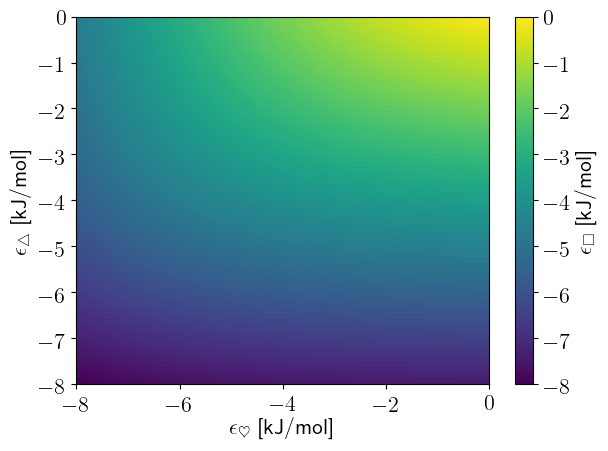

In [16]:
rcParams["text.usetex"] = true
rcParams["text.latex.preamble"] = [raw"\usepackage{amssymb}"] # to use \Box

fig, ax = plt.subplots()

pcolor(E♡, E△, ϵ□, vmax=0.0)
cbar = colorbar()
cbar.set_label(L"$\epsilon_\square$ [kJ/mol]")
xlabel(L"$\epsilon_\heartsuit$ [kJ/mol]")
ylabel(L"$\epsilon_\bigtriangleup$ [kJ/mol]")
tight_layout()

savefig("epsilon_square.pdf", format="pdf")

\begin{equation}
    \frac{\partial X}{\partial \beta} = -kT^2\frac{\partial X}{\partial T}
\end{equation} so
\begin{equation}
    \frac{\frac{\partial X}{\partial \beta}}{\frac{\partial Y}{\partial \beta}} = \frac{\frac{\partial X}{\partial T}}{\frac{\partial Y}{\partial T}}
\end{equation}

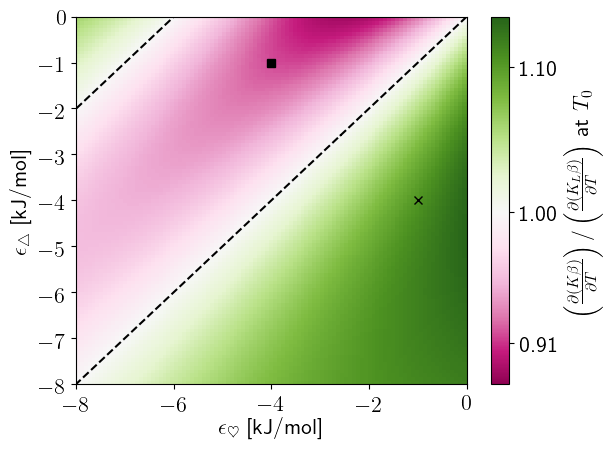

In [17]:
fig, ax = plt.subplots()

# norm = PyPlot.cm.colors.Normalize(vmax=maximum(abs.(Z)), vmin=-maximum(abs.(Z)))
norm = PyPlot.cm.colors.LogNorm(vmax=max_ratio, vmin=1/max_ratio)

pclr = pcolor(E♡, E△, ∂Kβ_∂β_MORF_vs_L, norm=norm,
         cmap=PyPlot.cm.PiYG)

where_ticks = [1/1.1, 1.0, 1.1]
cbar = colorbar(label=L"$\left(\frac{\partial (K\beta) }{\partial T}\right) / \left(\frac{\partial (K_L\beta)}{\partial T}\right)$ at $T_0$")
cbar.update_bruteforce(pclr)  # https://github.com/matplotlib/matplotlib/issues/12155/
cbar.set_ticks(where_ticks)
cbar.set_ticklabels([@sprintf("%.2f", t) for t in where_ticks])  # horizontal colorbar

contour(E♡, E△, ∂Kβ_∂β_MORF_vs_L, [1.0], colors="k", linestyles="dashed")
# _ϵ = collect(range(min_energy, stop=-δ, length=100))
# plot(_ϵ, _ϵ .+ δ, color="gray", linestyle="--")

xlabel(L"$\epsilon_\heartsuit$ [kJ/mol]")
ylabel(L"$\epsilon_\bigtriangleup$ [kJ/mol]")
yticks(min_energy:0)
# axis("equal")
# xlim(minimum(X), 0.0)
# ylim(minimum(Y), 0.0)
# # βδ = 3
RMS_MOF_less_T_sensitivity = [-4.0, -1.0] # pink (square)
RMS_MOF_more_T_sensitivity = [-1.0, -4.0]

# # βδ = 2
# RMS_MOF_less_T_sensitivity = [-2.0, -0.2] # pink
# RMS_MOF_more_T_sensitivity = reverse(RMS_MOF_less_T_sensitivity)

# βδ = 1
# RMS_MOF_less_T_sensitivity = [-1.05, -0.1] # pink
# RMS_MOF_more_T_sensitivity = [-0.1, -2.2]

plot(RMS_MOF_more_T_sensitivity[1], RMS_MOF_more_T_sensitivity[2], marker="x", color="k")
plot(RMS_MOF_less_T_sensitivity[1], RMS_MOF_less_T_sensitivity[2], marker="s", color="k")

tight_layout()

savefig("dKbeta.pdf", format="pdf")

illustrate different temperature dependences via isobars

more T-sensitive material: MORF material with:
	δ = 3.000
	ϵ♡ = -1.000
	ϵ△ = -4.000
isobar for P = 0.5878259944461169
ϵ for corresponding Langmuir material [kJ/mol]: -3.5645776691953173
K(β) = 4.215038299445465
1 + KβP = 2.0
∂(Kβ)/∂β RMS-MOF = 11.359048654185354
∂(Kβ)/∂β Langmuir = 10.279039726524347
less T-sensitive material: 

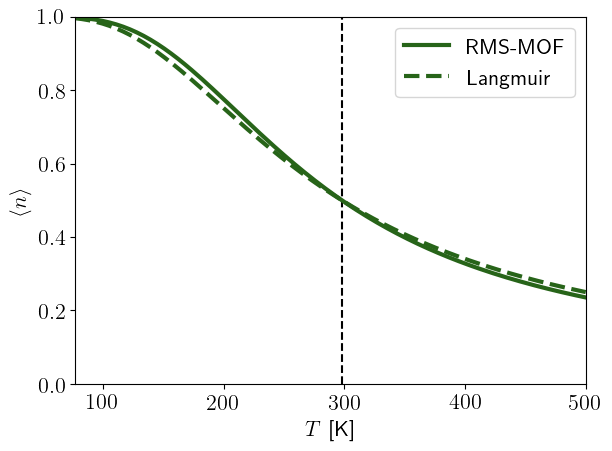

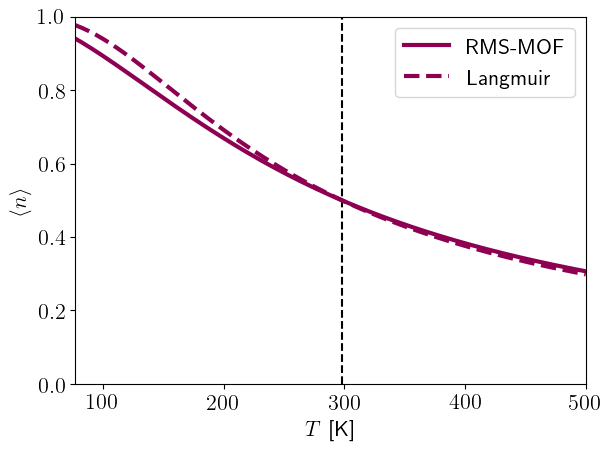

MORF material with:
	δ = 3.000
	ϵ♡ = -4.000
	ϵ△ = -1.000
isobar for P = 1.0739918323759083
ϵ for corresponding Langmuir material [kJ/mol]: -2.0712458211793683
K(β) = 2.307009239091472
1 + KβP = 2.0
∂(Kβ)/∂β RMS-MOF = 3.879349657209631
∂(Kβ)/∂β Langmuir = 4.23555818959635


┌ Warning: βP > 1
└ @ Main In[18]:20


In [18]:
function isobars_RMS_MOF_vs_Langmuir(material::Material, β::Float64, n::Float64, color; 
        savename::Union{Nothing, String}=nothing)
    P = n / (K(material, β) * β * (1 - n))
    println("isobar for P = ", P)
    
    ϵ = ϵ_for_same_K_L(material, β)
    println("ϵ for corresponding Langmuir material [kJ/mol]: ", ϵ)
    println("K(β) = ", K(material, β))
    println("1 + KβP = ", 1.0 + K(material, β) * β * P)
    
    figure()
    axvline(x=1/β / R, color="k", linestyle="--")
    
    println("∂(Kβ)/∂β RMS-MOF = ", ∂Kβ_∂β_MORF(material, β))
    println("∂(Kβ)/∂β Langmuir = ", ∂Kβ_∂β_Langmuir(β * ϵ))

    T_span = range(77, stop=500, length=150)
    β = 1.0 ./ (R * T_span)
    if maximum(β * P) > 1.0
        @warn "βP > 1"
    end
    
#     cnorm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(P), vmax=maximum(P))
#     P_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=cnorm, 
#         cmap=PyPlot.matplotlib.cm.get_cmap("viridis"))
#     P_to_color.set_array([])


#     for P_i in P
        # RMS-MOF
    n = [expected_n(material, β_i, P) for β_i in β]
    plot(T_span, n, 
        color=color, lw=3, label="RMS-MOF")
        #color=P_to_color.to_rgba(P_i), lw=3)

    ylim([0, 1])
    # Langmuir with same K at β = 1.0
    K_L = exp.(-β * ϵ)
    n_L = K_L .* β * P ./ (1 .+ K_L .* β * P)

    plot(T_span, n_L, 
        # color=P_to_color.to_rgba(P_i), lw=3, linestyle="--")
        color=color, lw=3, linestyle="--", label="Langmuir")
#     xscale("log")

#     end
#     colorbar(P_to_color, label=L"$P$ [energy]")
    xlim([minimum(T_span), maximum(T_span)])
    xlabel(L"$T$ [K]")
    ylabel(L"$\langle n \rangle$")
    legend()
    tight_layout()
    if ! isnothing(savename)
        savefig(savename, format="pdf")
    end
end

β = 1.0 / RT # (kJ/mol)^-1
n = 0.5 # to determine P for isobar
material = Material(δ, RMS_MOF_more_T_sensitivity...)
print("more T-sensitive material: ", material)
isobars_RMS_MOF_vs_Langmuir(material, β, n, PyPlot.cm.get_cmap(PyPlot.cm.PiYG, 2)(1.0),
    savename="more_T_sensitive.pdf")

material = Material(δ, RMS_MOF_less_T_sensitivity...)
print("less T-sensitive material: ", material)
isobars_RMS_MOF_vs_Langmuir(material, β, n, PyPlot.cm.get_cmap(PyPlot.cm.PiYG, 2)(0.0),
    savename="less_T_sensitive.pdf")

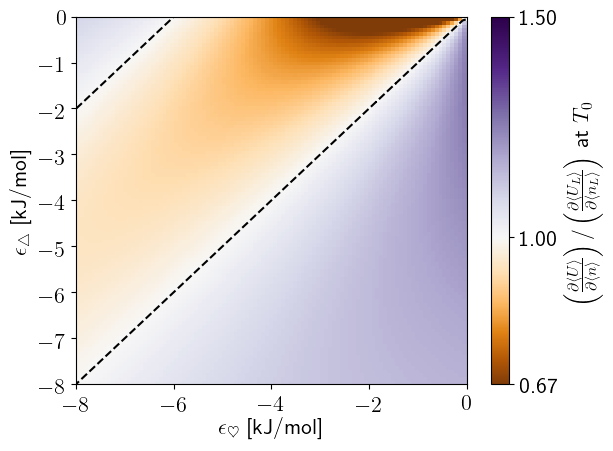

In [19]:
max_ratio = 1.5

figure()

norm = PyPlot.cm.colors.LogNorm(vmax=max_ratio, vmin=1/max_ratio)

pclr = pcolor(E♡, E△, dU_dn_MORF_vs_L, norm=norm,
         cmap=PyPlot.cm.PuOr)

where_ticks = [1/max_ratio, 1.0, max_ratio]
cbar = colorbar(label=L"$\left(\frac{\partial \langle U \rangle}{\partial \langle n \rangle}\right) / \left(\frac{\partial \langle U_L \rangle}{\partial \langle n_L \rangle}\right)$ at $T_0$",)
cbar.update_bruteforce(pclr)
cbar.set_ticks(where_ticks)
cbar.set_ticklabels([@sprintf("%.2f", t) for t in where_ticks])  # horizontal colorbar
# _ϵ = collect(range(min_energy, stop=-δ, length=100))
# plot(_ϵ, _ϵ .+ δ, color="gray", linestyle="--")

contour(E♡, E△, dU_dn_MORF_vs_L, [1.0], colors="k", linestyles="dashed")

xlabel(L"$\epsilon_\heartsuit$ [kJ/mol]")
ylabel(L"$\epsilon_\bigtriangleup$ [kJ/mol]")
yticks(min_energy:0)
tight_layout()

savefig("dU_dn.pdf", format="pdf")

# ring position

\begin{equation}
    \langle r \rangle = 
   \left(\frac{e^{-\beta \delta}}{1+e^{-\beta \delta}} \right)
   \left( \frac{1+e^{-\beta \epsilon_\heartsuit}\beta P}{1+K\beta P}\right),
\end{equation}

In [20]:
function expected_r(material::Material, β::Float64, P::Float64)
    p_Δ = exp(-β * material.δ) / (1 + exp(-β * material.δ)) # in two-state model for ring without gas
    return p_Δ * (1 + exp(-β * material.ϵ♡) * β * P) / (1 + K(material, β) * β * P)
end

expected_r (generic function with 1 method)

### show dependence on gas uptake

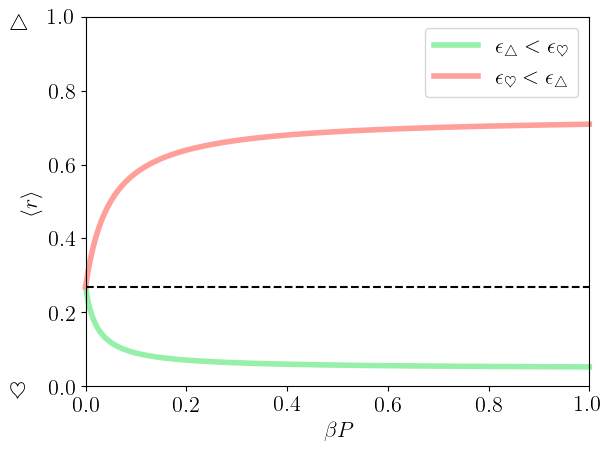

material where gas loves Δ: MORF material with:
	δ = 1.000
	ϵ♡ = -2.000
	ϵ△ = -4.000

material where gas loves ♡: MORF material with:
	δ = 1.000
	ϵ♡ = -4.000
	ϵ△ = -2.000



In [21]:
material_gas_loves_Δ = Material(1.0, -2.0, -4.0)
material_gas_loves_♡ = Material(1.0, -4.0, -2.0)
@assert isapprox(material_gas_loves_♡.δ, material_gas_loves_Δ.δ)

println("material where gas loves Δ: ", material_gas_loves_Δ)
println("material where gas loves ♡: ", material_gas_loves_♡)

r_no_gas = exp(-material_gas_loves_♡.δ) / (1 + exp(-material_gas_loves_♡.δ))

βP = range(0.0, stop=1.0, length=300)
r_gas_loves_Δ = [expected_r(material_gas_loves_Δ, 1.0, βP_i) for βP_i in βP]
r_gas_loves_♡ = [expected_r(material_gas_loves_♡, 1.0, βP_i) for βP_i in βP]

figure()
plot(βP, r_gas_loves_Δ, lw=4, color="C1",
    label=L"$\epsilon_\bigtriangleup <\epsilon_\heartsuit$",
    #label=L"$\beta \epsilon_\bigtriangleup=$" * @sprintf("%d", material_gas_loves_Δ.ϵΔ) * L"$<\beta \epsilon_\heartsuit=$" * @sprintf("%d", material_gas_loves_Δ.ϵ♡),
    clip_on=false
)
plot(βP, r_gas_loves_♡, lw=4, color="C2",
    label=L"$ \epsilon_\heartsuit <\epsilon_\bigtriangleup$",
    #label=L"$\beta \epsilon_\heartsuit=$" * @sprintf("%d", material_gas_loves_♡.ϵ♡) * L"$<\beta \epsilon_\bigtriangleup=$" * @sprintf("%d", material_gas_loves_♡.ϵΔ),
    clip_on=false
)
# text(0.6, .5, L"$\beta \delta=$" * @sprintf("%d", material_gas_loves_♡.δ))
axhline(y=r_no_gas, color="k", linestyle="--")
xlabel(L"$\beta P$")
ylabel(L"\langle r \rangle")
ylim([0.0, 1.0])
xlim([0, 1])
text(-0.15, -0.0225, L"$\heartsuit$")
text(-0.15, 1. - 0.0225, L"$\bigtriangleup$")
legend()
tight_layout()
savefig("expected_r.pdf", format="pdf")

### show dependence on temperature (an interesting case)

this is a property dependent on $n$.

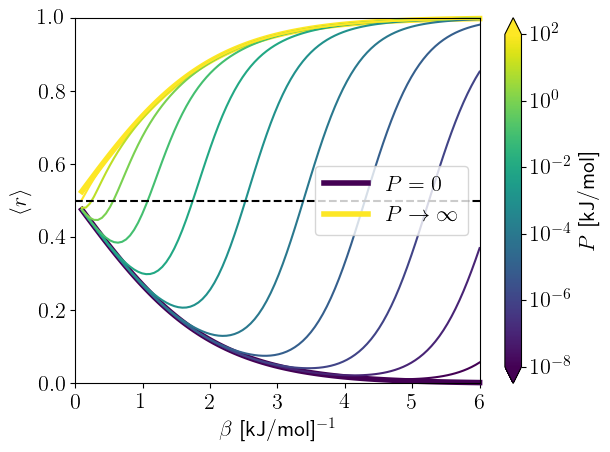

MORF material with:
	δ = 1.000
	ϵ♡ = -3.000
	ϵ△ = -1.000



In [22]:
material = Material(1.0, -3.0, -1.0)
println(material)
β = range(0.1, stop=6.0, length=100)

P = vcat([0.0], 10. .^ (-8:2))

r_empty = exp.(-β * material.δ) ./ (1.0 .+ exp.(-β * material.δ))
r_full = exp.(-β * (material.ϵ♡ + material.δ)) ./ (exp.(-β * material.ϵ△) .+ exp.(-β * (material.ϵ♡ + material.δ)))

cnorm = PyPlot.matplotlib.colors.LogNorm(vmin=minimum(P[2:end]), vmax=maximum(P))
P_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=cnorm, cmap=PyPlot.matplotlib.cm.get_cmap("viridis"))
P_to_color.set_array([])

fig, ax = subplots()
plot(β, r_empty, color=P_to_color.to_rgba(minimum(P)), label=L"$P=0$", lw=4, clip_on=false)
plot(β, r_full, color=P_to_color.to_rgba(maximum(P)), label=L"$P\rightarrow \infty$", lw=4, clip_on=false)
xlabel(L"$\beta$ [kJ/mol]$^{-1}$")
ylabel(L"$\langle r \rangle$")
for P_i in P
    r = [expected_r(material, β_i, β_i * P_i) for β_i in β]
    plot(β, r, color=P_to_color.to_rgba(P_i), clip_on=false)
end
axhline(y=0.5, color="k", linestyle="--")
colorbar(P_to_color, label=L"$P$ [kJ/mol]", extend="both")
ylim([0, 1])
xlim([0, maximum(β)])
legend()
tight_layout()
savefig("expected_r_T_dependence.pdf", format="pdf")

illustrate $S$

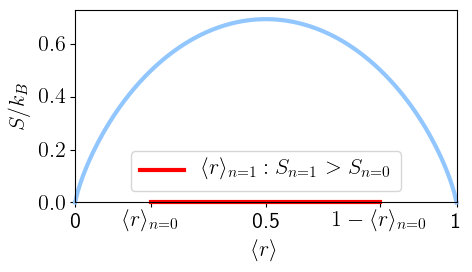

In [23]:
S_over_kb(p::Float64) = - p * log(p) - (1 - p) * log(1 - p)

p = range(0.0, stop=1.0, length=150)
s = [S_over_kb(p_i) for p_i in p]
s[1] = 0.0
s[end] = 0.0
r_0 = 0.2

figure(figsize=(5, 3))
ylabel(L"$S/k_B$")
xlabel(L"$\langle r \rangle$")
plot(p, s, linewidth=3, clip_on=false)
plot([r_0, 1-r_0], [0, 0], c="r", 
    clip_on=false, linewidth=3, 
    label=L"$\langle r\rangle_{n=1} : S_{n=1} > S_{n=0}$")
ylim(ymin=0.0)
xlim([0, 1])
legend()
xticks([0.0, r_0, 0.5, 1.0 - r_0, 1.0], 
    ["0", L"$\langle r \rangle_{n=0}$", "0.5", L"$1-\langle r \rangle_{n=0}$", "1"])
tight_layout()
savefig("entropy.pdf", format="pdf")

show()